# Detecting Spam Emails

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

nltk.download("stopwords")

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings

warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
data_file="/content/spam_ham_dataset.csv"

In [5]:
df = pd.read_csv(data_file)

In [6]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [9]:
df.isnull().sum()

,0
Unnamed: 0,0
label,0
text,0
label_num,0


In [11]:
df.shape

(5171, 4)

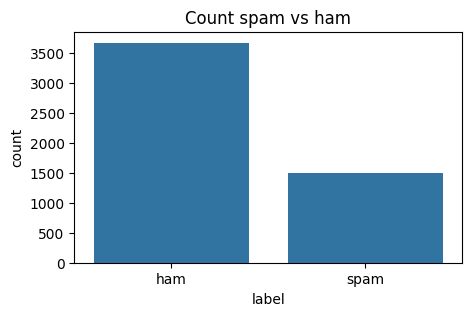

In [13]:
plt.figure(figsize=(5,3))

sns.countplot(x="label", data=df)

plt.title("Count spam vs ham")

plt.show()

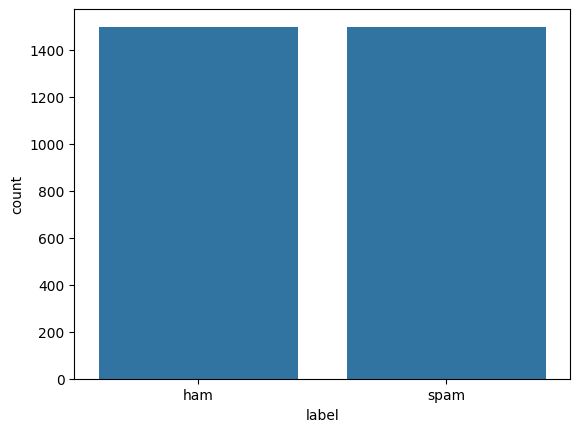

In [14]:
ham_df = df[df["label"] == "ham"]
spam_df = df[df["label"] == "spam"]

balanced_ham_df = ham_df.sample(n=len(spam_df), random_state=13)

new_df = pd.concat([balanced_ham_df, spam_df]).reset_index(drop=True)


sns.countplot(x="label", data=new_df)
plt.show()

In [16]:
from typing import List

punc_list = string.punctuation

translator = str.maketrans('', '', string.punctuation)

stopwords_list = stopwords.words("english")

def drop_cols(df: pd.DataFrame, cols_to_drop: List[str])-> pd.DataFrame:
  df= df.drop(columns=cols_to_drop)
  return df

def clean_text(text: str) -> str:
    text = text.replace("Subject:", "")

    text = text.translate(translator)

    wordset = []

    for word in text.split():
        word = word.lower()

        if word not in stopwords_list:
            wordset.append(word)

    return " ".join(wordset)

In [18]:
new_df["text"] = new_df["text"].apply(clean_text)

In [20]:
new_df = drop_cols(new_df, ["Unnamed: 0", "label_num"])

In [21]:
new_df.head()

,label,text
0,ham,southern union 03 01 prod austin spot deal 690...
1,ham,june 2000 availabilities 2 nd revision changes...
2,ham,september production estimate daren fyi bob fo...
3,ham,neon discussion october 25 discussion outline ...
4,ham,enrononline launch monday 18 th pleased announ...


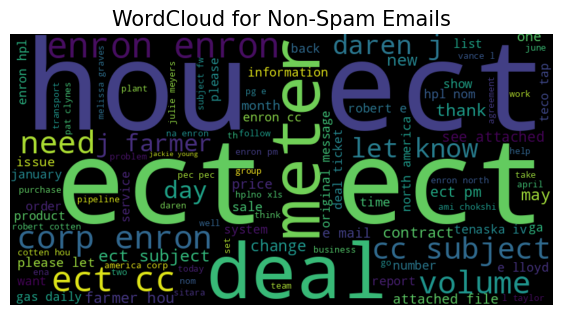

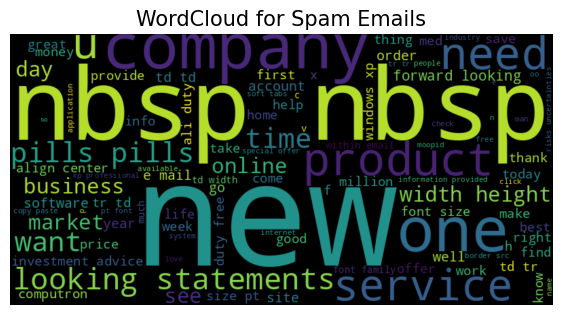

In [22]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(new_df[new_df['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(new_df[new_df['label'] == 'spam'], typ='Spam')

In [27]:
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder()

label_df = new_df.copy()

label_df["label"] = le.fit_transform(label_df["label"])

label_df.head()

,label,text
0,0,southern union 03 01 prod austin spot deal 690...
1,0,june 2000 availabilities 2 nd revision changes...
2,0,september production estimate daren fyi bob fo...
3,0,neon discussion october 25 discussion outline ...
4,0,enrononline launch monday 18 th pleased announ...


In [28]:
le.classes_

array(['ham', 'spam'], dtype=object)

In [29]:
new_df = label_df

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_df["text"], new_df["label"], test_size=0.2, random_state=13)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)

test_sequences = tokenizer.texts_to_sequences(X_test)

In [31]:
max_len = 100
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, y_train,
    validation_data=(test_sequences, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.5356 - loss: 0.6880 - val_accuracy: 0.9483 - val_loss: 0.3058 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9404 - loss: 0.2550 - val_accuracy: 0.9383 - val_loss: 0.2168 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9550 - loss: 0.1786 - val_accuracy: 0.9417 - val_loss: 0.2128 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9615 - loss: 0.1594 - val_accuracy: 0.9483 - val_loss: 0.1983 - learning_rate: 0.0010


In [34]:
test_loss, test_accuracy = model.evaluate(test_sequences, y_test)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9470 - loss: 0.3070
Test Loss : 0.3057861626148224
Test Accuracy : 0.9483333230018616


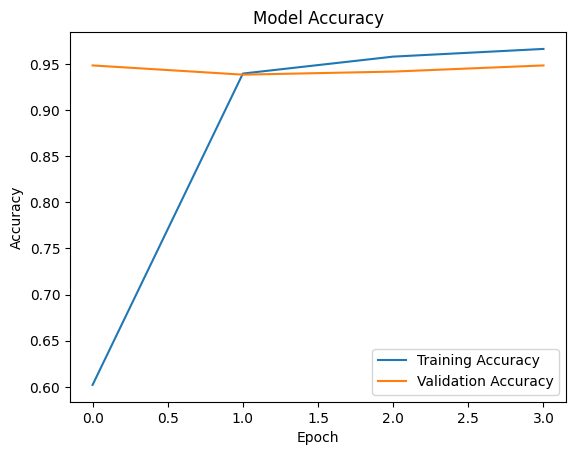

In [35]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()